## Homework 20: Tuning of models using hyperopt and GridSearch
**Conditions**: 
- Dataset: Diabetes
- Metric: Accuracy

**Goal**: get results of XGBoostClassifier, AdaBoostClassifier, CatBoostClassifier with default parameters, tune models with hyperopt and GridSearch, and compare results

**Acceptance criteria**: Tuned models must have higher accuracy 

Importing the needed libraries

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from hyperopt import fmin, tpe, hp, Trials, space_eval
from catboost import CatBoostClassifier

Loading diabetes dataset

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=names)

# Raw data analysis

In [3]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Check For Missing, Null, Duplicate and Unique Values

In [5]:
info = pd.DataFrame(data.isnull().sum(),columns=["IsNull"])
info.insert(1,"IsNa",data.isna().sum(),True)
info.insert(2,"Duplicate",data.duplicated().sum(),True)
info.insert(3,"Unique",data.nunique(),True)
info.insert(4,"Min",data.min(),True)
info.insert(5,"Max",data.max(),True)
info.T

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
IsNull,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
IsNa,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
Duplicate,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
Unique,17.0,136.0,47.0,51.0,186.0,248.0,517.000,52.0,2.0
Min,0.0,0.0,0.0,0.0,0.0,0.0,0.078,21.0,0.0
Max,17.0,199.0,122.0,99.0,846.0,67.1,2.420,81.0,1.0


Simple logic check

In [6]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


First Glance Questions:
1. Pregnancies: Number of times pregnant
Pregnancies max = 17 => can one woman have 17 children? Probably
2. Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
Glucose min = 0 => impossible
3. BloodPressure: Diastolic blood pressure (mm Hg)
BloodPressure min = 0 => impossible
4. SkinThickness: Triceps skin fold thickness (mm)
SkinThickness min = 0 => impossible
5. Insulin: 2-Hour serum insulin (mu U/ml)
Insulin min = 0 => impossible
6. BMI: Body mass index (weight in kg/(height in m)^2)
BMI min = 0 => impossible
7. Diabetes pedigree function
Not sure what it is but looks fine
8. Age (years) looks ok

Conclusion: zero values of Glucose, BloodPressure, SkinThickness, Insulin, BMI can be replaced with median

In [7]:
cols= data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']]
for col in cols:
    median = data[col].median()
    data.loc[data[col]<=0,col] = median

In [8]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,27.334635,94.652344,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,9.229014,105.547598,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,23.000000,30.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,31.250000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# EDA

Correlations

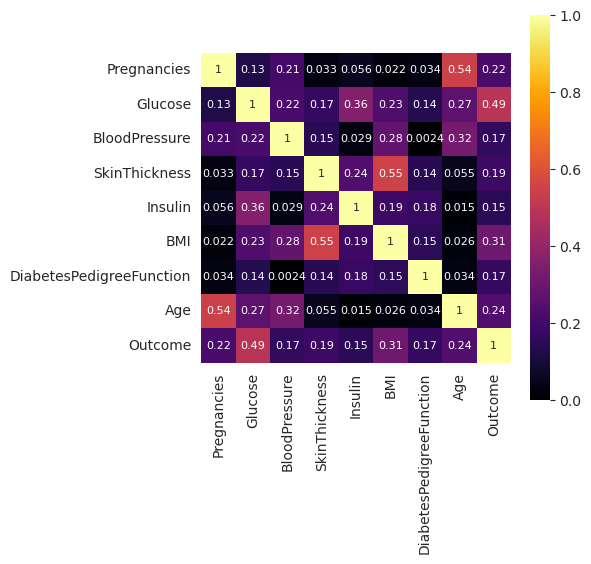

In [9]:
corr = data.corr()
plt.subplots(figsize=(5, 5))
sns.heatmap(
    abs(corr),
    vmax=1.0, vmin=0.0,
    annot=True, annot_kws={'size': 8},
    square=True, cmap='inferno'
)
plt.show()

Conclusion: no high correlations between any features

## Models

In [10]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

## XGBClassifier

<p style="color:red;">1. Getting results of XGBClassifier with default papameters</p>

In [12]:
# Create and fit model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [13]:
# Make predictions
y_pred = model.predict(X_test)

# Model evalution
xgb_def_acc = accuracy_score(y_pred, y_test)
print("XGBoost accuracy with default parameters: ", xgb_def_acc)

XGBoost accuracy with default parameters:  0.75


<p style="color:red;">2. Tuning XGBClassifier with hyperopt</p>

In [14]:
def objective(params):
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy  # We use negative accuracy as Hyperopt minimizes the objective function

In [15]:
space = {
    'n_estimators': hp.choice('n_estimators', range(100, 500)),  # Integer values
    'max_depth': hp.choice('max_depth', range(1, 10)),  # Integer values
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),  # Integer values
    'subsample': hp.uniform('subsample', 0.1, 1.0),  # Floating-point values
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),  # Floating-point values
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),  # Floating-point values
    'gamma': hp.uniform('gamma', 0.1, 0.5),  # Floating-point values
}

In [16]:
trials = Trials()

In [17]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,  # Number of optimization iterations
            trials=trials)

100%|██████████| 100/100 [00:40<00:00,  2.47trial/s, best loss: -0.8020833333333334]


In [18]:
print("Best Hyperparameters:", best)
best_params = space_eval(space, best)
print("Best Accuracy:", -objective(best_params))

Best Hyperparameters: {'colsample_bytree': 0.1814263558072819, 'gamma': 0.10680977509219958, 'learning_rate': 0.17885131020566772, 'max_depth': 0, 'min_child_weight': 4.0, 'n_estimators': 30, 'subsample': 0.6289556141042856}
Best Accuracy: 0.8020833333333334


In [19]:
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.1814263558072819, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.10680977509219958, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.17885131020566772, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=4.0, missing=nan, monotone_constraints=None,
              n_estimators=130, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [20]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
xgb_hyp_acc = accuracy_score(y_test, y_pred)
print("Accuracy of tuned XGBClassifier:", xgb_hyp_acc)

Accuracy of tuned XGBClassifier: 0.8020833333333334


<p style="color:red;">3. Tuning XGBClassifier with GridSearch</p>

In [21]:
# Can't use many parameters due to memory capacty
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}
xgb_boost = xgb.XGBClassifier()

In [22]:
grid_search = GridSearchCV(xgb_boost, param_grid, cv=5, scoring='accuracy')

In [23]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...in=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1.0],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [24]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'learning_rate': 1.0, 'n_estimators': 50}


In [25]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
xgb_grd_acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", xgb_grd_acc)

Test Accuracy: 0.7708333333333334


## AdaBoostClassifier

<p style="color:blue;">1. Getting results of AdaBoostClassifier with default papameters</p>

In [26]:
# Create and fit model
model = AdaBoostClassifier()
model.fit(X_train, y_train)

AdaBoostClassifier()

In [27]:
# Make predictions
y_pred = model.predict(X_test)

# Model evaluations
ada_def_acc = accuracy_score(y_pred, y_test)
print("AdaBoost accuracy with defauls parameters: ", ada_def_acc)

AdaBoost accuracy with defauls parameters:  0.765625


In [28]:
def objective(params):
    model = AdaBoostClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy  # Hyperopt minimizes the objective function

In [29]:
space = {
    'n_estimators': hp.choice('n_estimators', range(100, 500)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5)
}

In [30]:
trials = Trials()

In [31]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,  # Number of optimization iterations
            trials=trials)

100%|██████████| 100/100 [01:46<00:00,  1.06s/trial, best loss: -0.7942708333333334]


In [32]:
print("Best Hyperparameters:", best)
best_params = space_eval(space, best)
print("Best Accuracy:", -objective(best_params))

Best Hyperparameters: {'learning_rate': 0.039189165514251084, 'n_estimators': 284}
Best Accuracy: 0.7942708333333334


In [33]:
model = AdaBoostClassifier(**best_params)
model.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.039189165514251084, n_estimators=384)

In [34]:
# Make predictions
y_pred = model.predict(X_test)

# Model evaluation
ada_hyp_acc = accuracy_score(y_pred, y_test)
print("AdaBoost accuracy: ", ada_hyp_acc)

AdaBoost accuracy:  0.7942708333333334


<p style="color:blue;">3. Tuning AdaBoostClassifier with GridSearch</p>

In [35]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    # You can add more hyperparameters to tune here
}

ada_boost = AdaBoostClassifier()

In [36]:
grid_search = GridSearchCV(ada_boost, param_grid, cv=5, scoring='accuracy')

In [37]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1.0],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [38]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 200}


In [39]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
ada_grd_acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", ada_grd_acc)

Test Accuracy: 0.78125


## CatBoostClassifier

<p style="color:orange;">1. Getting results of CatBoostClassifier with default papameters</p>

In [40]:
# Create and fit model
model = CatBoostClassifier()
model.fit(X_train, y_train)

Learning rate set to 0.006846
0:	learn: 0.6895597	total: 49ms	remaining: 48.9s
1:	learn: 0.6866166	total: 51.2ms	remaining: 25.5s
2:	learn: 0.6829903	total: 56.2ms	remaining: 18.7s
3:	learn: 0.6798033	total: 59.8ms	remaining: 14.9s
4:	learn: 0.6771880	total: 63ms	remaining: 12.5s
5:	learn: 0.6738601	total: 65.2ms	remaining: 10.8s
6:	learn: 0.6711160	total: 67.2ms	remaining: 9.53s
7:	learn: 0.6680287	total: 69.3ms	remaining: 8.59s
8:	learn: 0.6652557	total: 71.3ms	remaining: 7.85s
9:	learn: 0.6613909	total: 73.4ms	remaining: 7.26s
10:	learn: 0.6586095	total: 75.7ms	remaining: 6.81s
11:	learn: 0.6553764	total: 78.1ms	remaining: 6.43s
12:	learn: 0.6522641	total: 79.8ms	remaining: 6.06s
13:	learn: 0.6493954	total: 81.9ms	remaining: 5.77s
14:	learn: 0.6459474	total: 83.6ms	remaining: 5.49s
15:	learn: 0.6430261	total: 86.1ms	remaining: 5.29s
16:	learn: 0.6398171	total: 87.9ms	remaining: 5.08s
17:	learn: 0.6371303	total: 89.6ms	remaining: 4.89s
18:	learn: 0.6344277	total: 91.3ms	remaining: 4.

In [41]:
# Make predictions
y_pred = model.predict(X_test)

# Model evaluation
cat_def_acc = accuracy_score(y_pred, y_test)
print("CatBoost accuracy: ", cat_def_acc)

CatBoost accuracy:  0.7682291666666666


<p style="color:orange;">2. Tuning CatBoostClassifier with hyperopt</p>

In [42]:
def objective(params):
    model = CatBoostClassifier(**params, verbose=0)  # Set verbose to 0 to avoid verbose output
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy  # Hyperopt minimizes the objective function

In [43]:
space = {
    'iterations': hp.quniform('iterations', 100, 1000, 1),
    'learning_rate': hp.loguniform('learning_rate', -4, 0),
    'depth': hp.quniform('depth', 1, 10, 1),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10)
}

In [44]:
trials = Trials()

In [45]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,  # Number of optimization iterations
            trials=trials)

100%|██████████| 100/100 [01:54<00:00,  1.14s/trial, best loss: -0.8020833333333334]


In [46]:
print("Best Hyperparameters:", best)
best_params = space_eval(space, best)
print("Best Accuracy:", -objective(best_params))

Best Hyperparameters: {'depth': 1.0, 'iterations': 144.0, 'l2_leaf_reg': 7.665010074275139, 'learning_rate': 0.04146978652414551}
Best Accuracy: 0.8020833333333334


In [47]:
model = CatBoostClassifier(**best_params)
model.fit(X_train, y_train)

0:	learn: 0.6875060	total: 506us	remaining: 72.4ms
1:	learn: 0.6800058	total: 734us	remaining: 52.1ms
2:	learn: 0.6723135	total: 1.19ms	remaining: 55.9ms
3:	learn: 0.6655335	total: 1.38ms	remaining: 48.2ms
4:	learn: 0.6601440	total: 1.54ms	remaining: 42.9ms
5:	learn: 0.6539547	total: 1.72ms	remaining: 39.6ms
6:	learn: 0.6493640	total: 1.88ms	remaining: 36.9ms
7:	learn: 0.6440629	total: 2.06ms	remaining: 35ms
8:	learn: 0.6397200	total: 2.22ms	remaining: 33.3ms
9:	learn: 0.6356424	total: 2.39ms	remaining: 32ms
10:	learn: 0.6318341	total: 2.57ms	remaining: 31ms
11:	learn: 0.6282613	total: 2.74ms	remaining: 30.2ms
12:	learn: 0.6248015	total: 2.9ms	remaining: 29.3ms
13:	learn: 0.6206695	total: 3.08ms	remaining: 28.6ms
14:	learn: 0.6162189	total: 3.25ms	remaining: 28ms
15:	learn: 0.6134168	total: 3.45ms	remaining: 27.6ms
16:	learn: 0.6095282	total: 3.65ms	remaining: 27.2ms
17:	learn: 0.6063448	total: 3.83ms	remaining: 26.8ms
18:	learn: 0.6027888	total: 4.12ms	remaining: 27.1ms
19:	learn: 0.5

In [48]:
# Make predictions
y_pred = model.predict(X_test)

# Model evaluate
cat_hyp_acc = accuracy_score(y_pred, y_test)
print("CatBoost accuracy: ", cat_hyp_acc)

CatBoost accuracy:  0.8020833333333334


<p style="color:orange;">3. Tuning CatBoostClassifier with GridSearch</p>

In [49]:
param_grid = {
    'iterations': [50, 100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}
cat_boost = CatBoostClassifier()

In [50]:
grid_search = GridSearchCV(cat_boost, param_grid, cv=5, scoring='accuracy')

In [51]:
grid_search.fit(X_train, y_train)

0:	learn: 0.6907552	total: 1.28ms	remaining: 62.6ms
1:	learn: 0.6885332	total: 2.6ms	remaining: 62.5ms
2:	learn: 0.6863485	total: 3.76ms	remaining: 59ms
3:	learn: 0.6842222	total: 4.92ms	remaining: 56.6ms
4:	learn: 0.6818930	total: 5.97ms	remaining: 53.8ms
5:	learn: 0.6798208	total: 7.4ms	remaining: 54.3ms
6:	learn: 0.6774358	total: 9.7ms	remaining: 59.6ms
7:	learn: 0.6752752	total: 10.8ms	remaining: 56.8ms
8:	learn: 0.6731407	total: 11.9ms	remaining: 54.4ms
9:	learn: 0.6712909	total: 17.8ms	remaining: 71.3ms
10:	learn: 0.6689665	total: 23.5ms	remaining: 83.4ms
11:	learn: 0.6671743	total: 25.3ms	remaining: 80.1ms
12:	learn: 0.6650537	total: 26.8ms	remaining: 76.3ms
13:	learn: 0.6629719	total: 28.2ms	remaining: 72.6ms
14:	learn: 0.6609698	total: 29.4ms	remaining: 68.5ms
15:	learn: 0.6585666	total: 30.6ms	remaining: 65ms
16:	learn: 0.6564249	total: 34.4ms	remaining: 66.7ms
17:	learn: 0.6542557	total: 35.8ms	remaining: 63.7ms
18:	learn: 0.6523793	total: 36.9ms	remaining: 60.3ms
19:	learn:

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fcd658a9360>,
             param_grid={'iterations': [50, 100, 500, 1000],
                         'learning_rate': [0.01, 0.1, 0.5, 1.0]},
             scoring='accuracy')

In [52]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'iterations': 1000, 'learning_rate': 0.01}


In [53]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
cat_grd_acc = accuracy_score(y_test, y_pred)
print("Test Accuracy of CatBoostClassifier with GridSearch:", cat_grd_acc)

Test Accuracy of CatBoostClassifier with GridSearch: 0.7578125


In [54]:
results = {'Parameters': ['Default', 'Hyperopt', 'GridSearch'], 'XGB Accuracy': [xgb_def_acc, xgb_hyp_acc, xgb_grd_acc], 'Ada Accuracy': [ada_def_acc, ada_hyp_acc, ada_grd_acc], 'Cat Accuracy': [cat_def_acc, cat_hyp_acc, cat_grd_acc]}

In [55]:
res = pd.DataFrame(results)
res

,Parameters,XGB Accuracy,Ada Accuracy,Cat Accuracy
0,Default,0.750000,0.765625,0.768229
1,Hyperopt,0.802083,0.794271,0.802083
2,GridSearch,0.770833,0.781250,0.757812


## CONCLUSION
Hyperopt helps to tune model parameters and get better results.
GridSearch is not the best option for models with a large amount of hyperparameters
Also, hyperopt is much faster than GridSearch